In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from environments import ARESEAOptimization
from environments.simulation import ExperimentalArea

In [2]:
# inches_per_point = 1 / 72.27
# textwidth = 487.8225
textwidth = 10
columnwdith = textwidth / 2

tex_fonts = {
#     # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 6,
#     "font.size": 6,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 6,
#     "xtick.labelsize": 6,
#     "ytick.labelsize": 6
}
plt.rcParams.update(tex_fonts)

# print(f"Columnwidth ca. {0.45*textwidth*inches_per_point} inches")

# plt.rc("font", family="serif")
# plt.rc("xtick", labelsize="x-small")
# plt.rc("ytick", labelsize="x-small")

In [3]:
df = pd.read_pickle("machine_studies/polished-donkey-996_000_20211202155327.pkl")

In [4]:
tmp = df["q3"].copy()
df["q3"] = df["cv"].copy()
df["cv"] = tmp

In [5]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

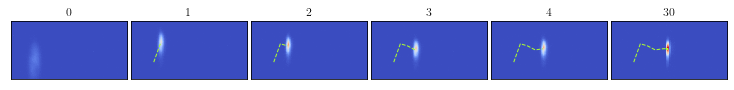

In [6]:
def plot_screens(df):
    df = df.copy()
    # fig, ax = plt.subplots(1, 6, figsize=(textwidth*inches_per_point,textwidth*inches_per_point/4))
    fig, ax = plt.subplots(1, 6, figsize=(textwidth,textwidth/4))
        
    extent = np.array(ExperimentalArea()._segment.AREABSCR1.extent) * 1000
    for (i, sample), ax in zip(enumerate([0, 1, 2, 3, 4, 30]), ax):
        img = df.loc[sample,"beam_image"].copy()
        vmax = df.iloc[-1]["beam_image"].max()
        # img[img < 0.01*vmax] = np.nan
        ax.set_title(sample)
        ax.imshow(img, vmin=0, vmax=vmax, extent=extent, cmap="coolwarm", interpolation="none")
        history_color = "greenyellow"
        ax.plot(df.loc[:sample,"mu_x"]*1000, df.loc[:sample,"mu_y"]*1000, c=history_color, ls="--", lw=1)
        # if sample > 0:
        #     ax.arrow(
        #         (df.loc[sample-1,"mu_x"]) * 1000,
        #         (df.loc[sample-1,"mu_y"]) * 1000,
        #         (df.loc[sample,"mu_x"]-df.loc[sample-1,"mu_x"]) * 1000,
        #         (df.loc[sample,"mu_y"]-df.loc[sample-1,"mu_y"]) * 1000,
        #         color=history_color,
        #         head_width=0.1,
        #         length_includes_head=True
        #     )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        # plt.grid(ls="--")
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1, 1)
    fig.tight_layout(pad=0)
    
    return fig

plot_screens(df)
plt.savefig("plots/screens.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/screens.png", dpi=300, bbox_inches="tight")
plt.show()

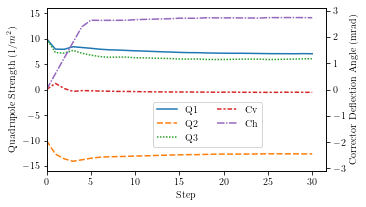

In [7]:
def plot_actuators(df):
    df = df.copy()
    # fig, ax0 = plt.subplots(figsize=(0.45*textwidth*inches_per_point,0.45*0.6*textwidth*inches_per_point))
    fig, ax0 = plt.subplots(figsize=(columnwdith,0.6*columnwdith))

    df.rename(columns={"step": "Step"}, inplace=True)
    sns.lineplot(data=df.set_index("Step")[["q1","q2","q3"]], legend=False, ax=ax0)
    # for step in [0, 1, 2, 3, 4, 30]:
    #     ax0.axvline(step, c="tab:gray", alpha=0.4, lw=1)
    ax0.set_axisbelow(True)
    ax0.set_xlim(0, None)
    ax0.set_ylim(-16, 16)
    ax0.set_ylabel("Quadrupole Strength ($1/m^2$)")
    ax1 = plt.twinx()
    df["Q1"] = np.nan
    df["Q2"] = np.nan
    df["Q3"] = np.nan
    df[["cv","ch"]] *= 1000
    df.rename(columns={"cv": "Cv", "ch": "Ch"}, inplace=True)
    sns.lineplot(data=df.set_index("Step")[["Q1","Q2","Q3","Cv","Ch"]], ax=ax1)
    ax1.set_ylim(-3.1, 3.1)
    ax1.set_ylabel("Corrector Deflection Angle (mrad)")
    ax1.legend(loc=(0.38,0.15), ncol=2)
    return fig

plot_actuators(df)
plt.savefig("plots/actuators.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/actuators.png", dpi=300, bbox_inches="tight")
plt.show()

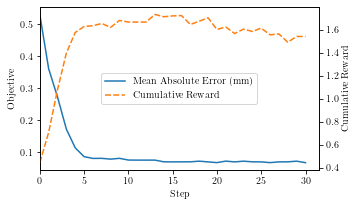

In [8]:
def plot_objective(df):
    df = df.copy()

    df.rename(columns={"step": "Step"}, inplace=True)
    df["Reward"] = df["reward"].apply(lambda x: float(x))
    df["Cumulative Reward"] = np.nan
    df["cumulative_reward"] = np.nan
    df.sort_index(inplace=True)
    for i in range(len(df)):
        df.loc[i,"cumulative_reward"] = df.loc[:i+1,"Reward"].sum()

    # fig, ax0 = plt.subplots(figsize=(0.45*textwidth*inches_per_point,0.45*0.6*textwidth*inches_per_point))
    fig, ax0 = plt.subplots(figsize=(columnwdith,0.6*columnwdith))
    df["mae"] *= 1000
    df.rename(columns={"mae": "Mean Absolute Error (mm)"}, inplace=True)
    sns.lineplot(data=df.set_index("Step")[["Mean Absolute Error (mm)","Cumulative Reward"]], ax=ax0)
    # plt.grid(ls="--")
    ax0.set_xlim(0, None)
    ax0.set_ylabel("Objective")
    ax0.legend(loc="center")
    ax0.set_axisbelow(True)
    # for step in [0, 1, 2, 3, 4, 30]:
    #     ax0.axvline(step, c="tab:gray", alpha=0.4, lw=1)
    ax1 = plt.twinx()
    sns.lineplot(data=df.set_index("Step")[["Cumulative Reward","cumulative_reward"]], ax=ax1, legend=False)
    ax1.set_ylabel("Cumulative Reward")
    
    return fig

plot_objective(df)
plt.savefig("plots/objective_and_cumulative_reward.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/objective_and_cumulative_reward.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
dfopa = pd.read_pickle("machine_studies/summary_operatorsvsagents.pkl")

# Compute MAE
dfopa["delta_mu_x"] = np.abs(dfopa["mup_x"] - dfopa["mu_x"])
dfopa["delta_mu_y"] = np.abs(dfopa["mup_y"] - dfopa["mu_y"])
dfopa["delta_sigma_x"] = np.abs(dfopa["sigmap_x"] - dfopa["sigma_x"])
dfopa["delta_sigma_y"] = np.abs(dfopa["sigmap_y"] - dfopa["sigma_y"])
dfopa["mae"] = (dfopa["delta_mu_x"] + dfopa["delta_mu_y"] + dfopa["delta_sigma_x"] + dfopa["delta_sigma_y"]) / 4

In [10]:
hannes = dfopa[dfopa["model"] == "Hannes"].set_index("step").loc[100:2700].reset_index()
hannes["step"] = hannes["step"] - 100
willi = dfopa[dfopa["model"] == "Willi"].set_index("step").loc[185:2500].reset_index()
willi["step"] = willi["step"] - 185

polished_donkey = dfopa[dfopa["model"] == "polished-donkey-996"].copy()
polar_lake = dfopa[dfopa["model"] == "polar-lake-997"].copy()
still_deluge = dfopa[dfopa["model"] == "still-deluge-998"].copy()

est_dtoper = 0.5
est_dtagent = 9.849028333333333

hannes["estimated_t"] = hannes["step"] * est_dtoper
willi["estimated_t"] = willi["step"] * est_dtoper
polished_donkey["estimated_t"] = polished_donkey["step"] * est_dtagent
polar_lake["estimated_t"] = polar_lake["step"] * est_dtagent
still_deluge["estimated_t"] = still_deluge["step"] * est_dtagent

hannes["model"] = "Operator 1"
willi["model"] = "Operator 2"
polished_donkey["model"] = "Agent 1"
polar_lake["model"] = "Agent 2"
still_deluge["model"] = "Agent 3"

hannes["Optimiser"] = "Human Operators"
willi["Optimiser"] = "Human Operators"
polished_donkey["Optimiser"] = "RL Agents"
polar_lake["Optimiser"] = "RL Agents"
still_deluge["Optimiser"] = "RL Agents"

dfopa2 = pd.concat([hannes, willi, polished_donkey, polar_lake, still_deluge], ignore_index=True)

dfopa2["Time (min)"] = dfopa2["estimated_t"] / 60
dfopa2["MAE"] = dfopa2["mae"] * 1e3

# op1mae = dfopa2.loc[dfopa2["model"] == "Operator 1",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Operator 1"})
# op2mae = dfopa2.loc[dfopa2["model"] == "Operator 2",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Operator 2"})
# ag1mae = dfopa2.loc[dfopa2["model"] == "Agent 1",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Agent 1"})
# ag2mae = dfopa2.loc[dfopa2["model"] == "Agent 2",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Agent 2"})
# ag3mae = dfopa2.loc[dfopa2["model"] == "Agent 3",["mae","Time (min)"]].set_index("Time (min)").rename(columns={"mae": "Agent 3"})
# opvsagmae = pd.concat([op1mae, op2mae, ag1mae, ag2mae, ag3mae], axis=1) * 1000

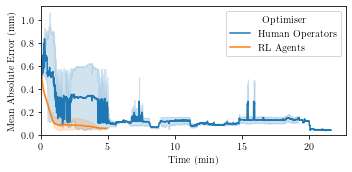

In [29]:
plt.figure(figsize=(columnwdith,0.5*columnwdith))
sns.lineplot(x="Time (min)", y="MAE", hue="Optimiser", data=dfopa2)
plt.xlim(0, None)
plt.ylim(0, None)
plt.ylabel("Mean Absolute Error (mm)")
plt.tight_layout()
plt.savefig("plots/operators_vs_agents_mae.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/operators_vs_agents_mae.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
convergence_limit = 3.3198e-6 * 4 * 1.5

def find_convergence(example):
    example = example.copy()
    example.set_index("Time (min)", inplace=True)
    example.sort_index(inplace=True)
    example["mae_diff"] = example["mae"].diff()
    example["abs_mae_diff"] = example["mae_diff"].abs()

    convergence_step = example.index.max()
    for i in example.index:
        x = all(example.loc[i:,"abs_mae_diff"] < convergence_limit)
        if x:
            convergence_step = i
            break
    
    return convergence_step

convsteps1 = dfopa2.groupby(["model","problem"]).apply(find_convergence)

convsteps2 = convsteps1.copy()
convsteps2 = convsteps2.reset_index().rename(columns={0: "convergence"})

convsteps2["method"] = convsteps2["model"].copy()
convsteps2.loc[convsteps2["model"].isin(["Agent 1","Agent 2","Agent 3"]),"method"] = "rl"
convsteps2.loc[convsteps2["model"].isin(["Operator 1","Operator 2"]),"method"] = "human"

result = convsteps2.groupby("method")["convergence"].median()

result.loc["rl"] = result.loc["rl"] # * 0.5 / 60
result.loc["human"] = result.loc["human"] # * 9.849028333333333 / 60

result

method
human    18.037500
rl        1.149053
Name: convergence, dtype: float64

In [13]:
# print(f"Median time by operators: {np.median([opvsagmae[opvsagmae['Operator 1'].notnull()].index.max(), opvsagmae[opvsagmae['Operator 2'].notnull()].index.max()])}")

In [14]:
# plt.figure(figsize=(columnwdith,0.6*columnwdith))
# sns.lineplot(data=opvsagmae)
# plt.xlim(0, None)
# plt.ylim(0, None)
# plt.ylabel("Mean Absolute Error (mm)")
# plt.tight_layout()
# plt.savefig("plots/operators_vs_agents_mae.pdf", dpi=300, bbox_inches="tight")
# plt.savefig("plots/operators_vs_agents_mae.png", dpi=300, bbox_inches="tight")
# plt.show()

In [15]:
dim = 100
env = ARESEAOptimization(backend="simulation", objective="mae", backendargs={"measure_beam": "direct"})
env.backend.next_misalignments = np.zeros(8)
env.reset()

mae_objectives = []
for q1 in np.linspace(-30, 30, num=dim):
    for q2 in np.linspace(-30, 30, num=dim):
        _, reward, _, _ = env.step(np.array([q1, q2, 0, 0, 0]))
        mae_objectives.append(reward)
mae_objectives = np.array(mae_objectives).reshape([dim,dim])

log_objectives = np.log(mae_objectives)

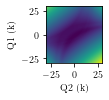

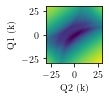

In [16]:
plt.figure(figsize=(0.5*columnwdith,0.5*0.6*columnwdith))
plt.imshow(mae_objectives, extent=[-30,30,-30,30])
plt.xlabel("Q2 (k)")
plt.ylabel("Q1 (k)")
plt.tight_layout()
plt.savefig("plots/q1q2_objective_mae.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/q1q2_objective_mae.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(0.5*columnwdith,0.5*0.6*columnwdith))
plt.imshow(log_objectives, extent=[-30,30,-30,30])
plt.xlabel("Q2 (k)")
plt.ylabel("Q1 (k)")
plt.tight_layout()
plt.savefig("plots/q1q2_objective_log.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/q1q2_objective_log.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
x = np.linspace(-1, 1, 100)
y = np.log(np.abs(x))

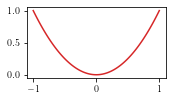

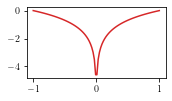

In [30]:
x = np.linspace(-1, 1, 100)

plt.figure(figsize=(0.5*columnwdith,0.5*0.6*columnwdith))
plt.plot(x, x**2, c="tab:red")
# plt.xlabel("Q2 (k)")
# plt.ylabel("Q1 (k)")
plt.tight_layout()
plt.savefig("plots/example1d_objective_mae.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/example1d_objective_mae.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(0.5*columnwdith,0.5*0.6*columnwdith))
plt.plot(x, np.log(np.abs(x)), c="tab:red")
# plt.xlabel("Q2 (k)")
# plt.ylabel("Q1 (k)")
plt.tight_layout()
plt.savefig("plots/example1d_objective_log.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/example1d_objective_log.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
neldermead = pd.concat([
    pd.read_pickle(".cache_3/nelder-mead-fdf-mae.pkl"),
    pd.read_pickle(".cache_3/nelder-mead-fdf.pkl"),
    pd.read_pickle(".cache_3/nelder-mead-fdf-log.pkl"),
    pd.read_pickle(".cache_3/nelder-mead-fdf-mse-initsimplex.pkl")
], ignore_index=True)
powell = pd.concat([
    pd.read_pickle(".cache_3/powell-fdf-mae.pkl"),
    pd.read_pickle(".cache_3/powell-fdf.pkl"),
    pd.read_pickle(".cache_3/powell-fdf-log.pkl"),
], ignore_index=True)
cobyla = pd.concat([
    pd.read_pickle(".cache_3/cobyla-fdf-mae.pkl"),
    pd.read_pickle(".cache_3/cobyla-fdf-mse.pkl"),
    pd.read_pickle(".cache_3/cobyla-fdf-log.pkl"),
    pd.read_pickle(".cache_3/cobyla-fdf-mae-1e-3.pkl"),
    pd.read_pickle(".cache_3/cobyla-fdf-mse-1e-3.pkl"),
    pd.read_pickle(".cache_3/cobyla-fdf-log-1e-3.pkl")
], ignore_index=True)
bayesian = pd.concat([
    pd.read_pickle(".cache_3/bayesian2-mae.pkl"),
    pd.read_pickle(".cache_3/bayesian2-mse.pkl"),
    pd.read_pickle(".cache_3/bayesian2-log.pkl")
], ignore_index=True)
randomsearch = pd.concat([
    pd.read_pickle(".cache_3/random-search-100.pkl"),
    pd.read_pickle(".cache_3/random-search-200.pkl"),
    pd.read_pickle(".cache_3/random-search.pkl"),
    pd.read_pickle(".cache_3/random-search-300b.pkl"),
    pd.read_pickle(".cache_3/random-search-1000.pkl")
], ignore_index=True)
nothing = pd.read_pickle(".cache_3/nothing.pkl")
reset = pd.concat([
    pd.read_pickle(".cache_3/set-fdf-10.pkl"),
    pd.read_pickle(".cache_3/set-zero.pkl")
], ignore_index=True)

models = ["polished-donkey-996", "polar-lake-997", "still-deluge-998"]
rl = pd.concat([pd.read_pickle(f".cache_3/{model}.pkl") for model in models], ignore_index=True)

rl["method"] = "reinforcement-learning"
neldermead.loc[neldermead["method"] == "nelder-mead-fdf","method"] = "nelder-mead-fdf-mse"
powell.loc[powell["method"] == "powell-fdf","method"] = "powell-fdf-mse"
randomsearch.loc[randomsearch["method"] == "random-search","method"] = "random-search-300"

evaluation = pd.concat([neldermead,powell,cobyla,bayesian,randomsearch,nothing,reset,rl], ignore_index=True)

# Compute MAE
evaluation["delta_mu_x"] = np.abs(evaluation["mup_x"] - evaluation["mu_x"])
evaluation["delta_mu_y"] = np.abs(evaluation["mup_y"] - evaluation["mu_y"])
evaluation["delta_sigma_x"] = np.abs(evaluation["sigmap_x"] - evaluation["sigma_x"])
evaluation["delta_sigma_y"] = np.abs(evaluation["sigmap_y"] - evaluation["sigma_y"])
evaluation["mae"] = (evaluation["delta_mu_x"] + evaluation["delta_mu_y"] + evaluation["delta_sigma_x"] + evaluation["delta_sigma_y"]) / 4

leq30 = evaluation["step"] <= 30
notrl = evaluation["method"] != "reinforcement-learning"

evaluation30 = evaluation[notrl | leq30]

simpler_evaluation30 = evaluation30[evaluation30["method"].isin([
    "bayesian2-log",
    "cobyla-fdf-mse-1e-3",
    "nelder-mead-fdf-mse-initsimplex",
    "nothing",
    "reinforcement-learning",
    "powell-fdf-mse",
    "random-search-100",
    "set-fdf-10",
    "set-zero"
])].copy()

In [20]:
simpler_evaluation30.rename(columns={"step": "Step", "mae": "MAE", "method": "Algorithm"}, inplace=True)

simpler_evaluation30.loc[simpler_evaluation30["Algorithm"] == "nelder-mead-fdf-mse-initsimplex","Algorithm"] = "Nelder-Mead"
simpler_evaluation30.loc[simpler_evaluation30["Algorithm"] == "powell-fdf-mse","Algorithm"] = "Powell"
simpler_evaluation30.loc[simpler_evaluation30["Algorithm"] == "cobyla-fdf-mse-1e-3","Algorithm"] = "COBYLA"
simpler_evaluation30.loc[simpler_evaluation30["Algorithm"] == "bayesian2-log","Algorithm"] = "Bayesian"
simpler_evaluation30.loc[simpler_evaluation30["Algorithm"] == "random-search-100","Algorithm"] = "Random"
simpler_evaluation30.loc[simpler_evaluation30["Algorithm"] == "reinforcement-learning","Algorithm"] = "RL"

simpler_evaluation30 = simpler_evaluation30[simpler_evaluation30["Algorithm"] != "nothing"]
simpler_evaluation30 = simpler_evaluation30[simpler_evaluation30["Algorithm"] != "set-fdf-10"]
simpler_evaluation30 = simpler_evaluation30[simpler_evaluation30["Algorithm"] != "set-zero"]

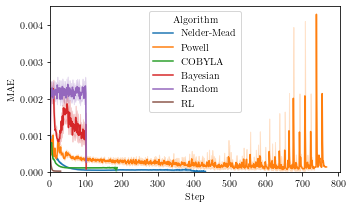

In [21]:
plt.figure(figsize=(columnwdith,0.6*columnwdith))
sns.lineplot(x="Step", y="MAE", hue="Algorithm", data=simpler_evaluation30)
plt.xlim(0, None)
plt.ylim(0, None)
# plt.yscale("log")
# plt.grid(ls="--")
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.savefig("plots/mae_over_time.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/mae_over_time.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
df = pd.read_pickle("machine_studies/summary_optimisersvsagents.pkl")

In [23]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

In [24]:
df["mae"] *= 1e3
df.rename(columns={"step": "Step", "mae": "Mean Absolute Error (mm)"}, inplace=True)
df.loc[df["method"]=="reinforcement-learning","Method"] = "RL"
df.loc[df["method"]=="nelder-mead-initsimplex","Method"] = "Nelder-Mead"

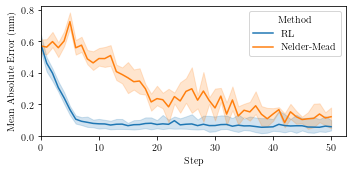

In [28]:
plt.figure(figsize=(columnwdith,0.5*columnwdith))
sns.lineplot(x="Step", y="Mean Absolute Error (mm)", hue="Method", data=df[df["Step"] <= 50])
plt.xlim(0, None)
plt.ylim(0, None)
plt.tight_layout()
plt.savefig("plots/rl_vs_neldermead.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/rl_vs_neldermead.png", dpi=300, bbox_inches="tight")
plt.show()